# Clause Analysis

**Method:**

The clauses found in each contract in the CUAD data will be extracted and vectorized via a count vectorizer.  This will be done in two ways and will utilize a bespoke tokenizer to treat each clause as a single token regardless of the number of words within it.  The first technique will be a straight count vectorizer and will capture the number of clause annotations found in the contract, the second will be a binary count vectorizer which will indicate if one or more clauses have been found in the contract. As analysis has indicated that 99.8% of contracts contain ‘Document Name’, and ‘Agreement Date’, these clauses will be omitted from the vectorization.

The resulting feature space will be reduced to a 2D representation via t-SNE with the random state fixed.  The 2D space will then be clustered using KMeans clustering.  By reducing the dimensionality, we address any concerns about clustering with KMeans in high dimensional space.  

To determine the best parameter configuration and cluster number, we will test maximum features in the range of 10, 15, 20 and None and range of clusters between 2 to 15 in the KMeans algorithm.  As we are treating individual clauses as tokens, we will only consider unigrams in this analysis.

The effectiveness of the clustering will then be measured using the ‘Elbow’ method and the SSE and S-DBW metrics.  
The percentage of each class that contains the respective vocabulary element (top features) will then be presented to enable interpretation.


## Section 1: Download Data & Extract Clause Of Interest

This uses a customized class (DownloadCUAD) to download the CUAD data and extract the required data to the working memory.

In [1]:
#Import required packages for section
from DownloadCUAD import DownloadCUAD, clean_clause

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\RichardWarburton\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#Download CUAD Data to local drive
DC = DownloadCUAD()
DC.setup()

#Extract data from CUAD
clause_data,raw_data = DC.extract_contracts()

CUAD data already downloaded & extracted!


## Section 2: Analysis of Named Clauses Within a Contract

The following applies a count and binary vectorization of the clauses found within the contract text

In [3]:
#Import required packages for section
import numpy as np
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from s_dbw import S_Dbw
from UsefulProjectFunctions import cluster_summary

### 2.1 Extract & Vectorize Clause Counts

Apply count and binary vectorization to the clause counts for each contract.

In [4]:
#Define list of clauses to ignore in the analysis
clauses_to_ignore = ['Document Name','Parties']

#Initated default dict of lists to append clauses to a key of contract name
contract_clauses = defaultdict(list)
bin_contract_clauses = defaultdict(list)
full_contract_clauses = defaultdict(list)

#For each data point, append the respective clause to the list with contract name key
for i in range(len(clause_data['contract title'])):
    
    #add clause to full clause list (i.e. non clauses ignored)
    full_contract_clauses[clause_data['contract title'][i]].append(clause_data['clause'][i])
    
    #Initate null lists if not found (Why needed ?!?!?!)
    if clause_data['contract title'][i] not in list(contract_clauses.keys()):
        contract_clauses[clause_data['contract title'][i]]
        bin_contract_clauses[clause_data['contract title'][i]]
    
    #If not an excluded clause, add to bin_contract_clauses
    if clause_data['clause'][i] not in contract_clauses[clause_data['contract title'][i]] + clauses_to_ignore:
        contract_clauses[clause_data['contract title'][i]].append(clause_data['clause'][i])
    
    #If not an excluded clause and not already added, add to bin_contract_clauses
    if clause_data['clause'][i] not in bin_contract_clauses[clause_data['contract title'][i]] + clauses_to_ignore:
        bin_contract_clauses[clause_data['contract title'][i]].append(clause_data['clause'][i])

### Section 2.2 Determine Contracts with Common Clauses

Determine how many contracts contain both of the clauses in the clauses_to_ignore list

In [5]:
#Initate dictionary to store counts by key
common_clauses = {}

#For each key in full_contract_clauses
for key in list(full_contract_clauses.keys()):
    #Initate counter
    z=0
    #For each clause in clauses_to_ignore
    for sp in clauses_to_ignore:
        #if the clause is in the clauses for the respective key
        if sp in full_contract_clauses[key]:
            #increment counter
            z+=1
            
    #set common_clauses key as count
    common_clauses[key]=z
    
#Determine where counts are == 2    
common_tot =(np.array(list(common_clauses.values()))==2).sum()

#Output Analysis
ln = len(list(common_clauses.values()))
print('{:.2%} of contracts have both of the excluded clauses'.format(common_tot/ln))

99.80% of contracts have both of the excluded clauses


### 2.3 Determine Optimal Paramater Configuration

Tune the model across the range of values outlined in the method

In [6]:
#Initate dictionary to hold multiple vector representations
vector_representations = {}
TSNE_representations = {}
feature_spaces = {}
vocab = {}

#Define range of n_grams to investigate
n_gram_rng =[(1,1)]
vectorisation_technique =['count','binary']
max_features_rng = [10,15,20,None]

#For each vectorisation approach
for approach in vectorisation_technique:
    #for each n_gram permutation
    for n_gram in n_gram_rng:
        #For each max_features value of interest
        for feats in max_features_rng:
            
            #Define the features to use
            if approach =='binary':
                features = bin_contract_clauses
            if approach == 'count':
                features = contract_clauses
            
            #Initate vectorizer using bespoke tokenizer (treats clause name as a single token)
            vectorizer =  CountVectorizer(input='content',
                                          lowercase=False,
                                          preprocessor=lambda x: x,
                                          tokenizer=lambda key: contract_clauses[key],
                                          ngram_range = n_gram,
                                          max_features = feats)
            
            #Assign output to the respective dictionary for storage.
            vector_representations[(approach,n_gram,feats)] = vectorizer.fit_transform(features).toarray()
            TSNE_representations[(approach,n_gram,feats)] = TSNE(n_components=2,random_state = 42).fit_transform(vector_representations[(approach,n_gram,feats)])
            vocab[(approach,n_gram,feats)] = vectorizer.vocabulary_

In [7]:
#Define range of cluster values (k) to investigate
k_rng = np.arange(2,16,1)

#Initate dictionaries to store results in a list
results = defaultdict(list)
score = defaultdict(list)
clustering = {}

#for each TSNE representation
for key in TSNE_representations.keys():
    #For each k of interest
    for k in k_rng:
        #Initate KMeans with paramaters of interest
        cluster = KMeans(n_clusters=k, random_state=42).fit(TSNE_representations[key])
        
        #Append results for respective k to results and score lists dictionaries with given key
        results[key].append(cluster.inertia_)
        score[key].append(S_Dbw(TSNE_representations[key], cluster.labels_, centers_id=None, 
                                method='Tong', alg_noise='bind',
                                centr='mean', nearest_centr=True,
                                metric='euclidean'))
        
        #Add KMeans model to storage
        clustering[(key,k)] = cluster

In [8]:
#Select Choosen Parameters (Selected in advance to aid plotting)
"""Selected in advance for formatting of plot for report"""
choosen_params =('binary',(1,1),10)
choosen_k = 6

#Extract choosen plot values
x_k = choosen_k
y_sse = np.array(results[choosen_params])[k_rng == choosen_k][0]
y_sdbw = np.array(score[choosen_params])[k_rng == choosen_k][0]

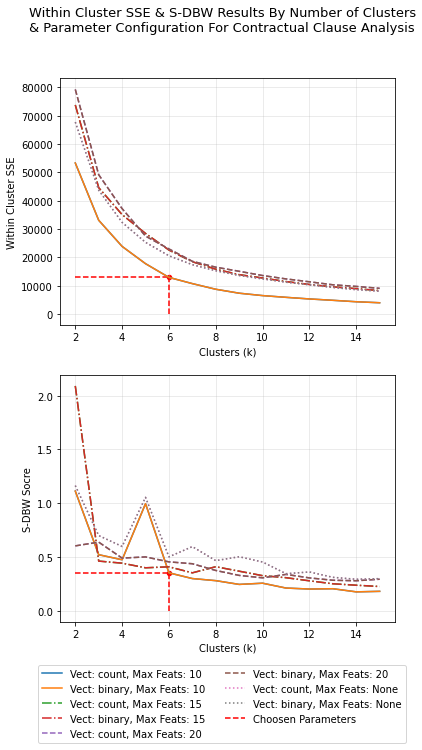

In [9]:
#Plot Results
fig, axs = plt.subplots(2, 1, figsize = (6,10))

lin_type ={10:'-',15:'-.',20:'--',None:':'}

for i in range(len(max_features_rng)):
    
    feats_to_plot = max_features_rng[i]
    
    for key in results.keys():
        if key[2] == feats_to_plot:
            
            axs[0].plot(k_rng, results[key],
                        label = 'Vect: {0}, Max Feats: {2}'.format(*key),
                        linestyle = lin_type[feats_to_plot])
            
            axs[1].plot(k_rng, score[key],
                        label = 'Vect: {0}, Max Feats: {2}'.format(*key),
                        linestyle = lin_type[feats_to_plot])

#Add chosen parmater call out to plot 0            
axs[0].scatter(x_k,y_sse,color = 'red',s = 20)
axs[0].vlines(x_k,ymin = 0, ymax = y_sse,color='red',linestyle='--',label ='Choosen Parameters')
axs[0].hlines(y_sse,xmin = 2, xmax = x_k,color='red',linestyle='--')

#Add chosen parmater call out to plot 1
axs[1].scatter(x_k,y_sdbw,color = 'red',s = 20)
axs[1].vlines(x_k,ymin = 0, ymax = y_sdbw,color='red',linestyle='--',label ='Choosen value')
axs[1].hlines(y_sdbw,xmin = 2, xmax = x_k,color='red',linestyle='--')
            
#format axs[0]            
axs[0].grid(alpha = 0.3)
#axs[0].set_title('SSE Score')
axs[0].set_xlabel('Clusters (k)')
axs[0].set_ylabel('Within Cluster SSE')

#axs[1].set_title('S-DBW Score')
axs[1].grid(alpha = 0.3)
axs[1].set_xlabel('Clusters (k)')
axs[1].set_ylabel('S-DBW Socre')

fig.suptitle('Within Cluster SSE & S-DBW Results By Number of Clusters\n& Parameter Configuration For Contractual Clause Analysis',size = 13)
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels,loc='lower center', ncol = 2,bbox_to_anchor = (0.5,-0.05))

plt.savefig('Fig7.png',bbox_inches='tight')
plt.show()

In [10]:
print('The Choosen Parameters are, vect ={}, n_gram = {}, max features = {}'.format(*choosen_params))
print('The choosen number of clusters is k = {}'.format((choosen_k)))
print('The scores for these parameters are SSE = {:.2f}, S-DBW = {:.4f}'.format(*(y_sse,y_sdbw)))

The Choosen Parameters are, vect =binary, n_gram = (1, 1), max features = 10
The choosen number of clusters is k = 6
The scores for these parameters are SSE = 12930.94, S-DBW = 0.3510


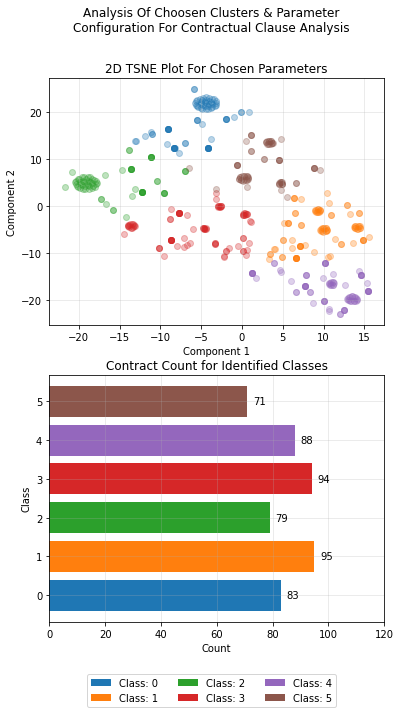

In [11]:
#Get vocab for optimal parameters
vocabs = vocab[choosen_params]

#build np array of chosen feature space 
if choosen_params[0] =='binary':
    features = np.array(list(bin_contract_clauses.values()),dtype=object)
if choosen_params[0] == 'count':
    features = np.array(list(contract_clauses.values()),dtype=object)

#Extract labels for chosen parameters
labs = clustering[(choosen_params,choosen_k)].labels_

#Determine label counts in clustered classes
classes,counts = np.unique(labs,return_counts=True)


#Plot Results
fig, axs = plt.subplots(2, 1, figsize = (6,10))

#Plot TSNE representation for chosen parameters
X = TSNE_representations[choosen_params]
for l in np.unique(labs):
    idx = labs == l
    c_idx = classes == l
    axs[0].scatter(X[:,0][idx],X[:,1][idx],alpha = 0.3, label = 'Class: {}'.format(l))
    axs[1].barh(classes[c_idx],counts[c_idx], label = 'Class: {}'.format(l))
    

#Format Plot
axs[0].set_title('2D TSNE Plot For Chosen Parameters')
axs[0].set_xlabel('Component 1')
axs[0].set_ylabel('Component 2')
axs[0].grid(alpha = 0.3)


axs[1].set_title('Contract Count for Identified Classes')
axs[1].grid(alpha = 0.3)
axs[1].set_xlabel('Count')
axs[1].set_ylabel('Class')
axs[1].set_yticks(classes)
axs[1].set_xlim([0,120])

for i, v in enumerate(counts):
    axs[1].text(v+2,i,str(v),va='center', color='black')

handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels,loc='lower center', ncol = 3,bbox_to_anchor = (0.5,-0))

plt.suptitle('Analysis Of Choosen Clusters & Parameter\nConfiguration For Contractual Clause Analysis')
plt.show()

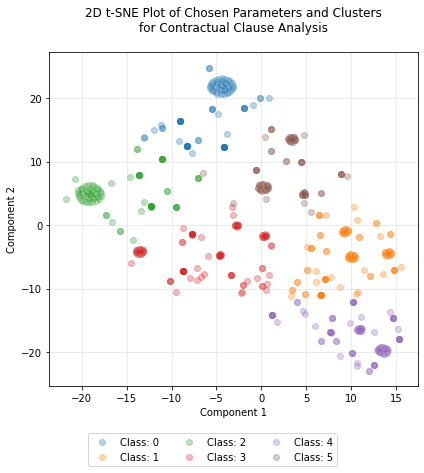

In [12]:
#Get vocab for optimal parameters
vocabs = vocab[choosen_params]

#build np array of chosen feature space 
if choosen_params[0] =='binary':
    features = np.array(list(bin_contract_clauses.values()),dtype=object)
if choosen_params[0] == 'count':
    features = np.array(list(contract_clauses.values()),dtype=object)

#Extract labels for chosen parameters
labs = clustering[(choosen_params,choosen_k)].labels_

#Determine label counts in clustered classes
classes,counts = np.unique(labs,return_counts=True)

#Plot Results
fig, axs = plt.subplots(figsize=(6,6))
#Plot TSNE representation for chosen parameters
X = TSNE_representations[choosen_params]
for l in np.unique(labs):
    idx = labs == l
    c_idx = classes == l
    axs.scatter(X[:,0][idx],X[:,1][idx],alpha = 0.3, label = 'Class: {}'.format(l))
    #axs[1].barh(classes[c_idx],counts[c_idx], label = 'Class: {}'.format(l))
    

#Format Plot
#axs.set_title('2D TSNE Plot For Chosen Parameters')
axs.set_xlabel('Component 1')
axs.set_ylabel('Component 2')
axs.grid(alpha = 0.3)

fig.legend(loc='lower center', ncol = 3,bbox_to_anchor = (0.5,-0.1))
axs.set_title('2D t-SNE Plot of Chosen Parameters and Clusters\nfor Contractual Clause Analysis\n')
plt.tight_layout()
plt.savefig('Fig8.png',bbox_inches='tight')

plt.show()

In [13]:
#Print summary of cluster values
cluster_summary(counts)

Minimum cluster contract count is: 71
Maximum cluster contract count is: 95
Mean cluster contract count is: 85.00
Variance of cluster contract count is: 8.43


### 2.4 Class Labelling Analysis

Output labelling analysis for the chosen parameter configuration

In [14]:
#Import required packages for section
from collections import Counter
import pandas as pd

In [15]:
#Initate memory for label counts and percentages
label_count ={}
label_perc ={}

#For each unique label
for l in np.unique(labs):
   
    #Initate vocab count for label
    vocab_count = {}
    
    #Identify the respective annotations
    idx = labs == l
    label_features = features[idx]
    
    #for each vocab token
    for v in vocabs:
        #initate counter for v in the respective class
        vocab_count[v] = 0
        #for each feature in the respective label features
        for feat in label_features:
            #increment counter if vocab element is in the feature feat
            if v in feat:
                vocab_count[v] += 1
                    
    #Add vocab counts for label count for the respective label
    label_count[l] = vocab_count
    
#Build dataframes of absolute and % results
aa,bb=np.unique(labs,return_counts=True)
act_results = pd.DataFrame(label_count)

perc_results = act_results/bb

#display % results
perc_results.style.format('{:.3f}').background_gradient()     

,0,1,2,3,4,5
Agreement Date,0.892,0.979,0.924,0.947,0.864,0.915
Effective Date,0.855,0.716,0.924,0.904,0.375,0.845
Expiration Date,0.940,0.853,0.987,0.830,0.364,0.930
Governing Law,1.000,0.979,0.987,0.957,0.250,1.000
Anti-Assignment,0.976,0.716,0.987,0.777,0.045,0.986
License Grant,0.940,0.095,0.759,0.351,0.114,0.915
Post-Termination Services,1.000,0.105,0.962,0.021,0.057,0.085
Audit Rights,0.747,0.179,0.785,0.447,0.023,0.408
Cap On Liability,0.699,0.000,0.835,0.989,0.091,0.704
Termination For Convenience,0.024,0.379,0.962,0.670,0.057,0.014
